Total patches: 1024
Patches to mask in vessel areas: 512
Patches to mask in background areas: 0
Total vessel patches: 117
Total background patches: 907


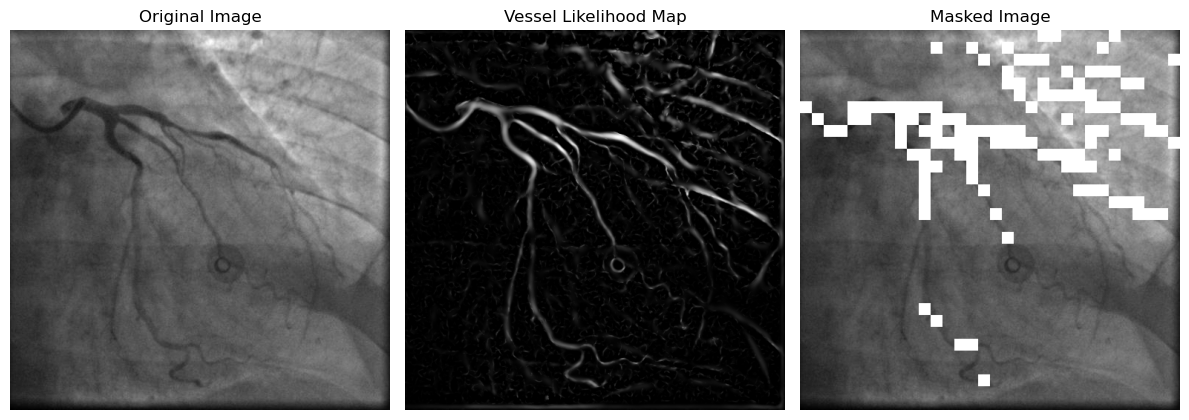

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi
from skimage import exposure

def generate_vessel_and_background_mask(image_path, mask_ratio=0.25, vessel_mask_ratio=0.2, patch_size=16):
    # Load the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Image not found. Please check the file path and try again.")
        return None

    # Preprocess the image
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)

    # Apply Frangi filter for vessel enhancement
    scale_range = np.arange(1, 6, 1)
    vessel_likelihood = np.zeros_like(enhanced, dtype=np.float64)
    for scale in scale_range:
        scale_response = frangi(enhanced, sigmas=(scale, scale + 1))
        vessel_likelihood = np.maximum(vessel_likelihood, scale_response)

    vessel_likelihood_normalized = exposure.rescale_intensity(vessel_likelihood, out_range=(0, 1))

    # Divide image into patches and calculate vessel likelihood per patch
    H, W = vessel_likelihood_normalized.shape
    patches = []
    vessel_patches = []
    background_patches = []

    for i in range(0, H, patch_size):
        for j in range(0, W, patch_size):
            patch = vessel_likelihood_normalized[i:i+patch_size, j:j+patch_size]
            avg_likelihood = patch.mean()
            patches.append((i, j))
            if avg_likelihood > 0.1:  # Threshold for vessel-like patches
                vessel_patches.append((avg_likelihood, (i, j)))
            else:
                background_patches.append((avg_likelihood, (i, j)))

    # Calculate the total number of patches to mask
    total_patches = len(patches)
    total_mask_count = int(total_patches * mask_ratio)

    # Calculate the number of vessel patches to mask
    vessel_mask_count = int(total_mask_count * vessel_mask_ratio)

    # Calculate the number of background patches to mask
    background_mask_count = total_mask_count - vessel_mask_count

    print(f"Total patches: {total_patches}")
    print(f"Patches to mask in vessel areas: {vessel_mask_count}")
    print(f"Patches to mask in background areas: {background_mask_count}")
    print(f"Total vessel patches: {len(vessel_patches)}")
    print(f"Total background patches: {len(background_patches)}")

    # Sort vessel patches by likelihood (highest first) and select
    vessel_patches.sort(reverse=True, key=lambda x: x[0])

    # If there aren't enough vessel patches to meet the required vessel mask count, take all available vessel patches
    if len(vessel_patches) < vessel_mask_count:
        print(f"Warning: Not enough vessel patches to mask {vessel_mask_count}. Using all available vessel patches.")
        vessel_mask_count = len(vessel_patches)

    selected_vessel_patches = [coord for _, coord in vessel_patches[:vessel_mask_count]]

    # Ensure enough background patches are available to fulfill the background mask count
    if len(background_patches) < background_mask_count:
        print(f"Warning: Not enough background patches to meet the mask count. Using all available background patches.")
        background_mask_count = len(background_patches)

    # Randomly shuffle and select background patches
    np.random.shuffle(background_patches)
    selected_background_patches = [coord for _, coord in background_patches[:background_mask_count]]

    # Create mask
    mask = np.zeros_like(image)
    for (i, j) in selected_vessel_patches + selected_background_patches:
        mask[i:i+patch_size, j:j+patch_size] = 255

    # Apply the mask to the original image
    masked_image = np.where(mask == 255, 255, image)

    # Display results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(vessel_likelihood_normalized, cmap='gray')
    plt.title("Vessel Likelihood Map")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(masked_image, cmap='gray')
    plt.title("Masked Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
image_path = r"C:\Users\Shakhnazar\Desktop\SWIN_MAE_DATA\data\train\14_085_4_0062_bmp.rf.22bd8c5b897aefff4285df5bd99a07d7.jpg"  # Replace with your image path
generate_vessel_and_background_mask(image_path, mask_ratio=0.5, vessel_mask_ratio=1, patch_size=16)
